Let's use the tools we have to perform a real world study. We'll be looking at the Wikipedia articles for all the current members of the United States congress. There are 532 members in total: 432 members of the House and 100 members of the Senate. After assembling a starting table with some basic information, I used analyze_csv to compute sentiment analysis metrics using the BERT, RoBERTa, and RoBERTuito models. Now we're ready to use plotting utitlies to draw meaningful conclusions about the dataset. Let's import the functions we'll be using.

In [1]:
from sentiment_plots import plot_group, plot_corrs

Now let's perform some group plots. We'll look at all the models we used, and let's also separate the data by party. I'm setting min_group_size to 3 because there are 2 Independent members in the Senate: we're just interested in the two major parties for this analysis.

In [2]:
models=['bert','roberta','robertuito']
input_filename='congress_analysis.csv'
label_cols=['Party']
min_group_size=3

Now let's look at all 5 group plotting metrics and see if we can identify any trends.

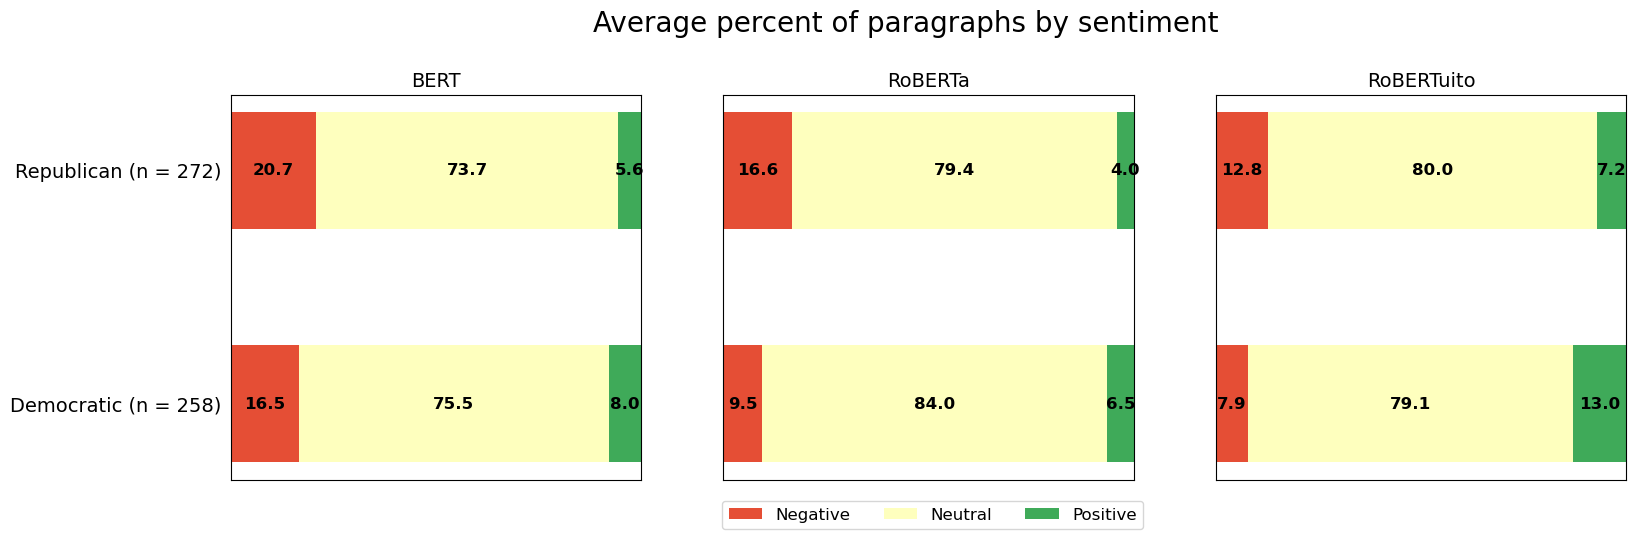

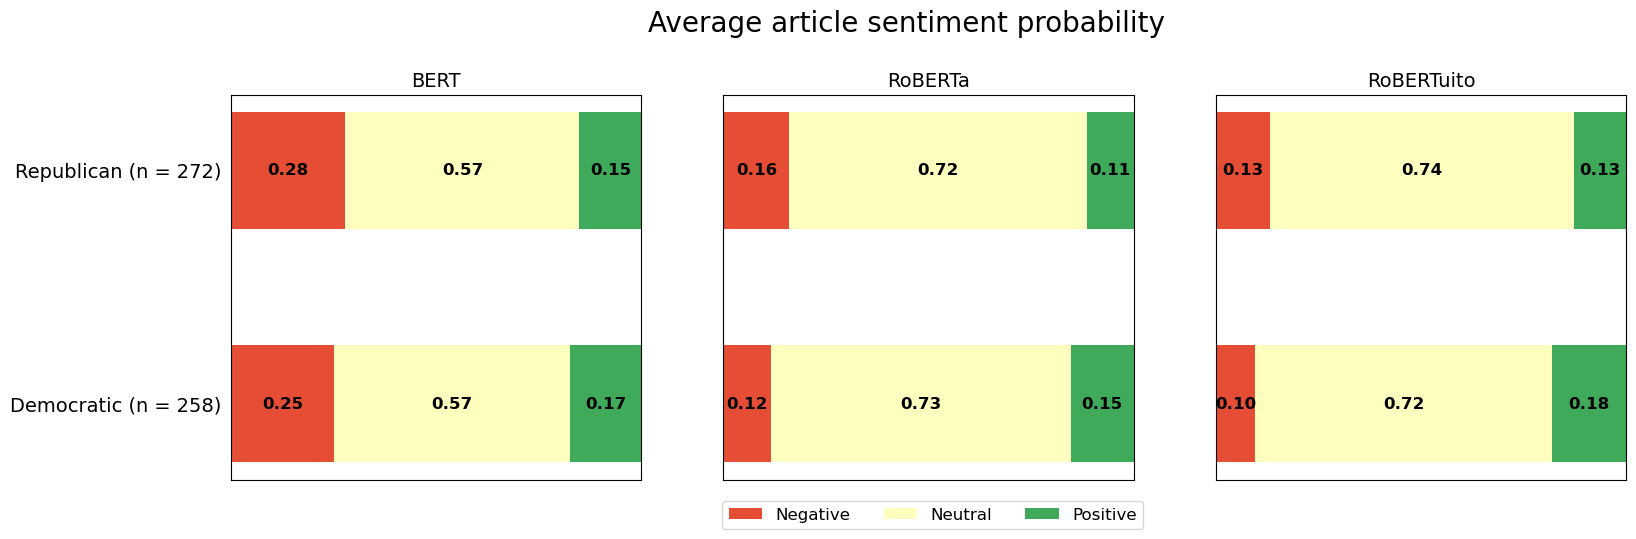

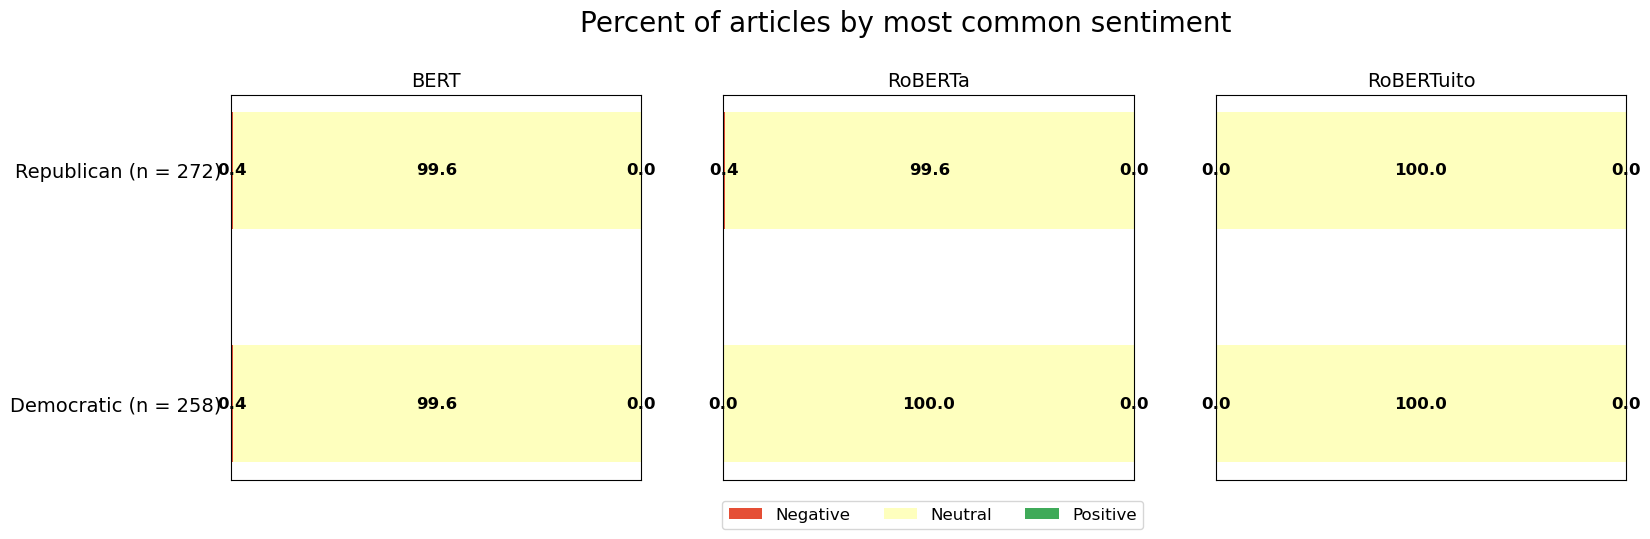

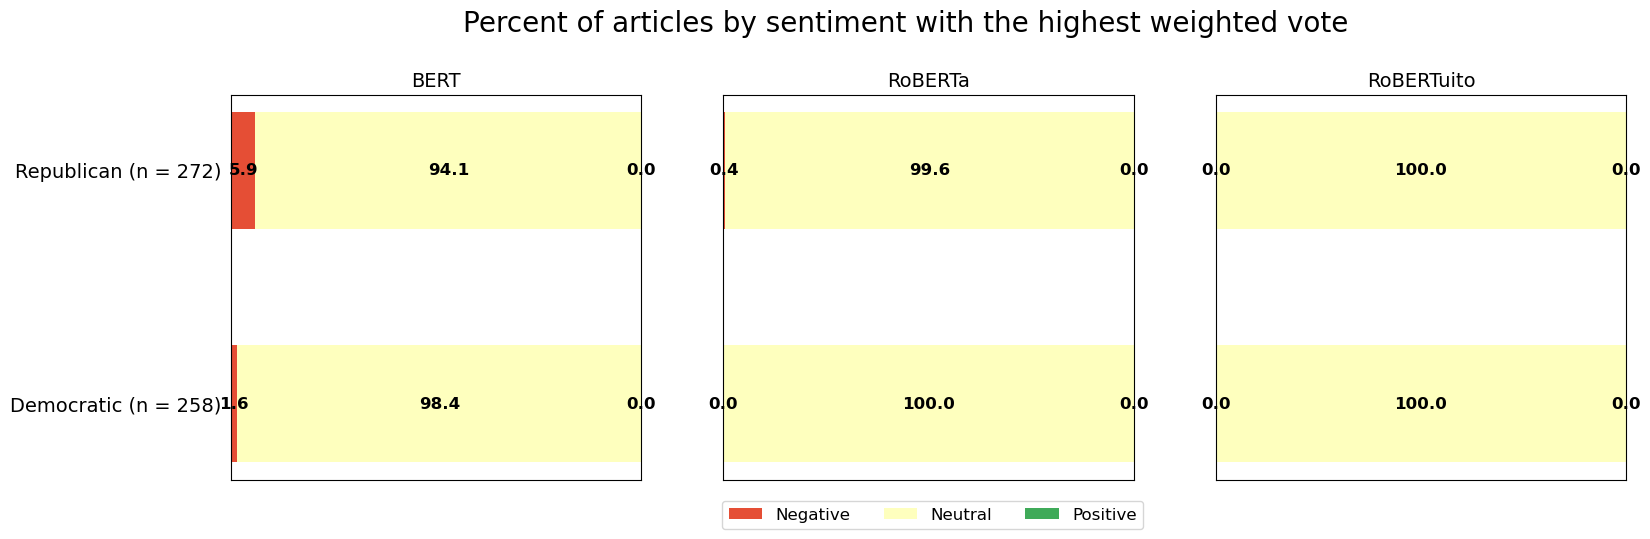

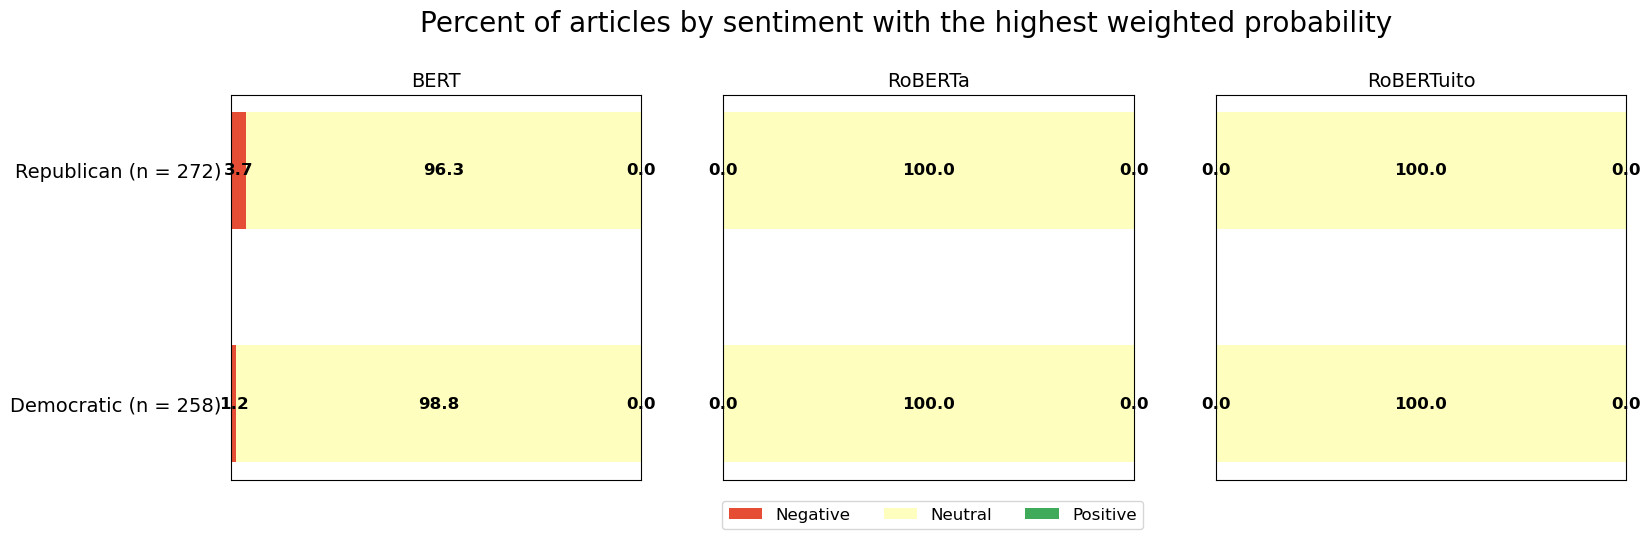

In [3]:
plot_group(models,input_filename,label_cols,plot_metric='avg_paragraph_percent',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='avg_article_prob',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='percent_most_common',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='percent_highest_weighted_vote',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='percent_highest_weighted_prob',save_fig=False,min_group_size=min_group_size)

Interesting! There are several findings here. The first is that the vast majority of the Wikipedia articles were classified as neutral by the three methods that give a single label for each article ('percent_most_common','percent_highest_weighted_vote', and 'percent_highest_weighted_prob'). This shouldn't be too surprising since Wikipedia is supposed to adopt a neutral tone in its articles. However, the BERT model did find significantly more negative articles amongst Republicans than Democrats. Furthermore, all models identified higher negative sentiment and lower positive sentiment for Republicans compared to Democrats when looking at the averages of methods that give three values for each article ('avg_paragraph_percent' and 'avg_article_prob'). Maybe you're thinking that this is because there is a small number of very negative Republican articles that are skewing the sample, and that if they were removed the sentiment would look pretty similar for both parties. Let's test that idea by considering only the articles that the BERT model classified as neutral using the 'percent_highest_weighted_vote' criterion.

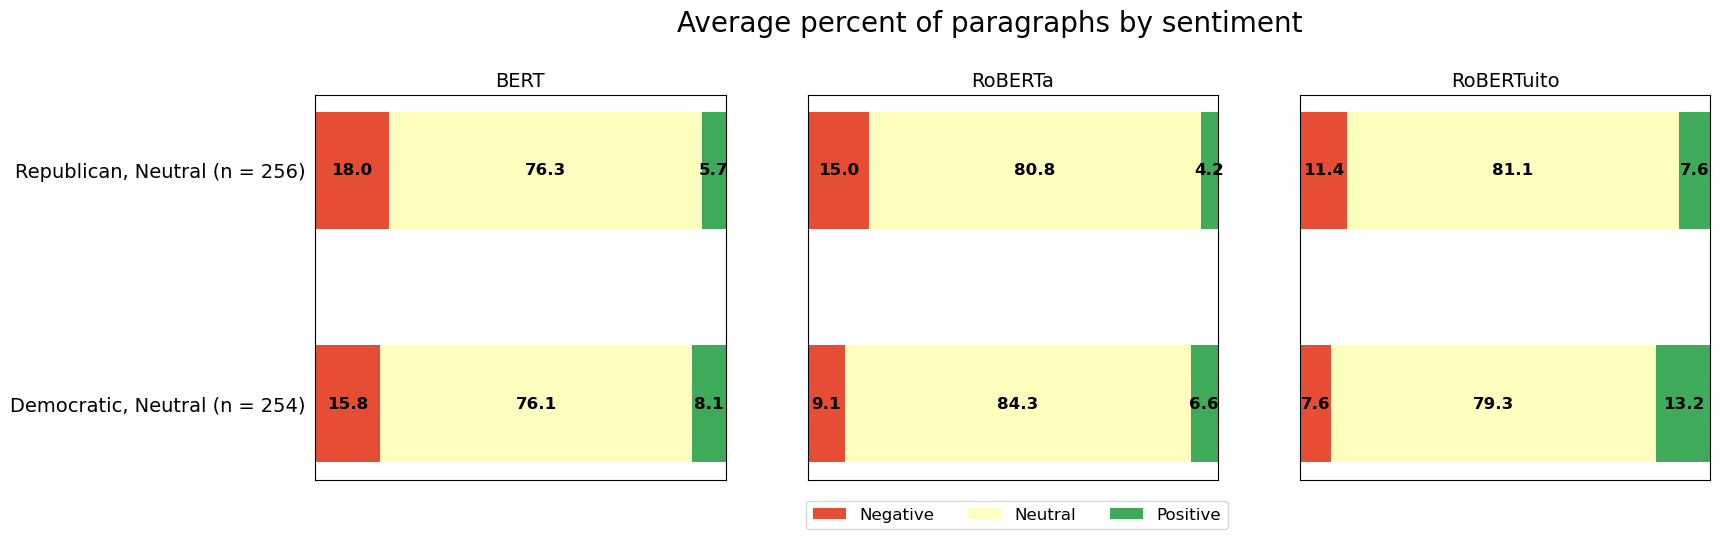

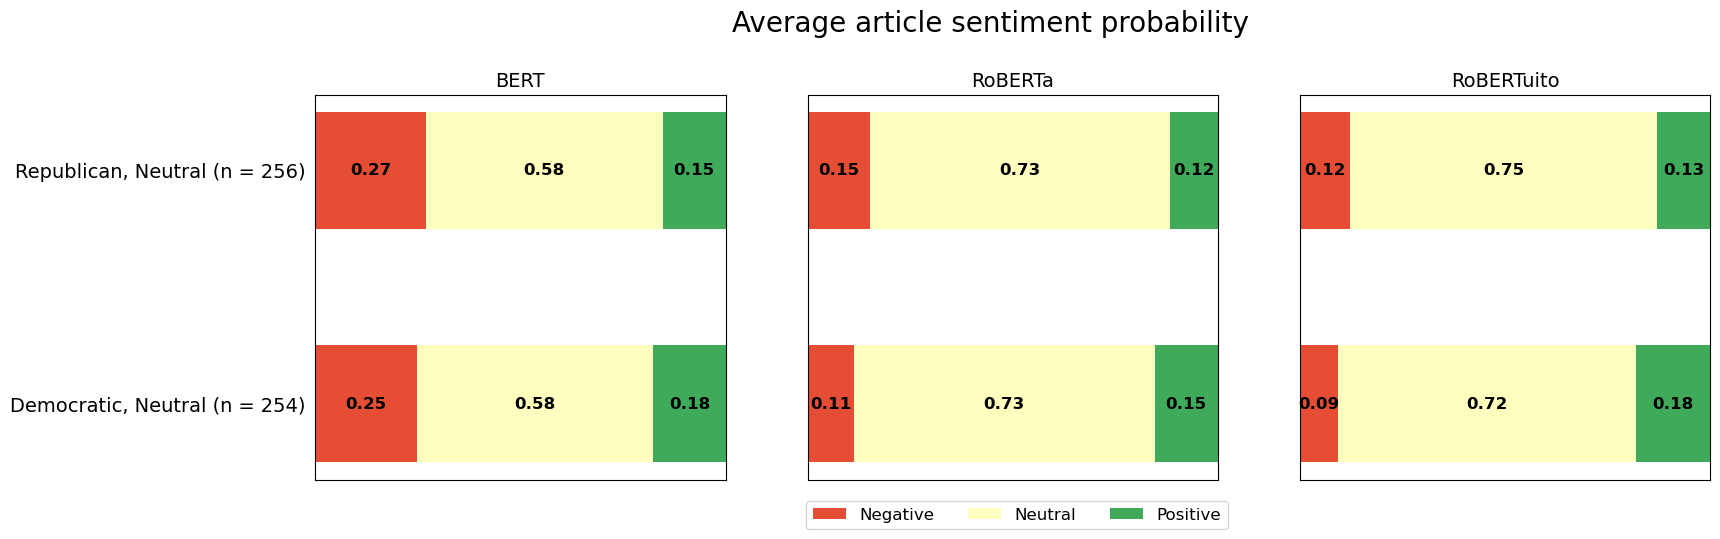

In [4]:
label_cols=['Party','Sentiment with highest weighted vote, BERT']
label_values=[True,['Neutral']]
plot_group(models,input_filename,label_cols,plot_metric='avg_paragraph_percent',save_fig=False,label_values=label_values,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='avg_article_prob',save_fig=False,label_values=label_values,min_group_size=min_group_size)

From this result, we can see that the trend remains even after removing the negative articles. This suggests even for articles that are classified as neutral overall, articles about Republicans tend to contain more negative sentiment and less positive sentiment than those about their Democratic counterparts. Next, let's see if there are any differences in sentiment between the House and the Senate. We'll look at all 5 group metrics like we did before.

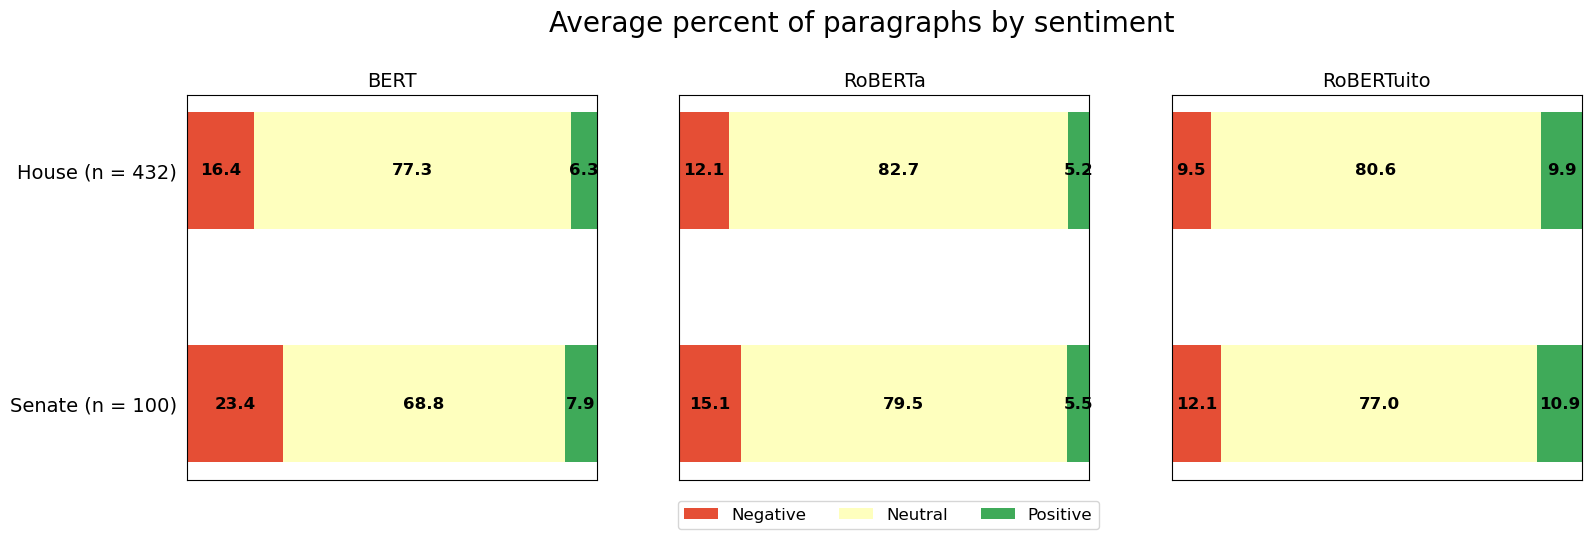

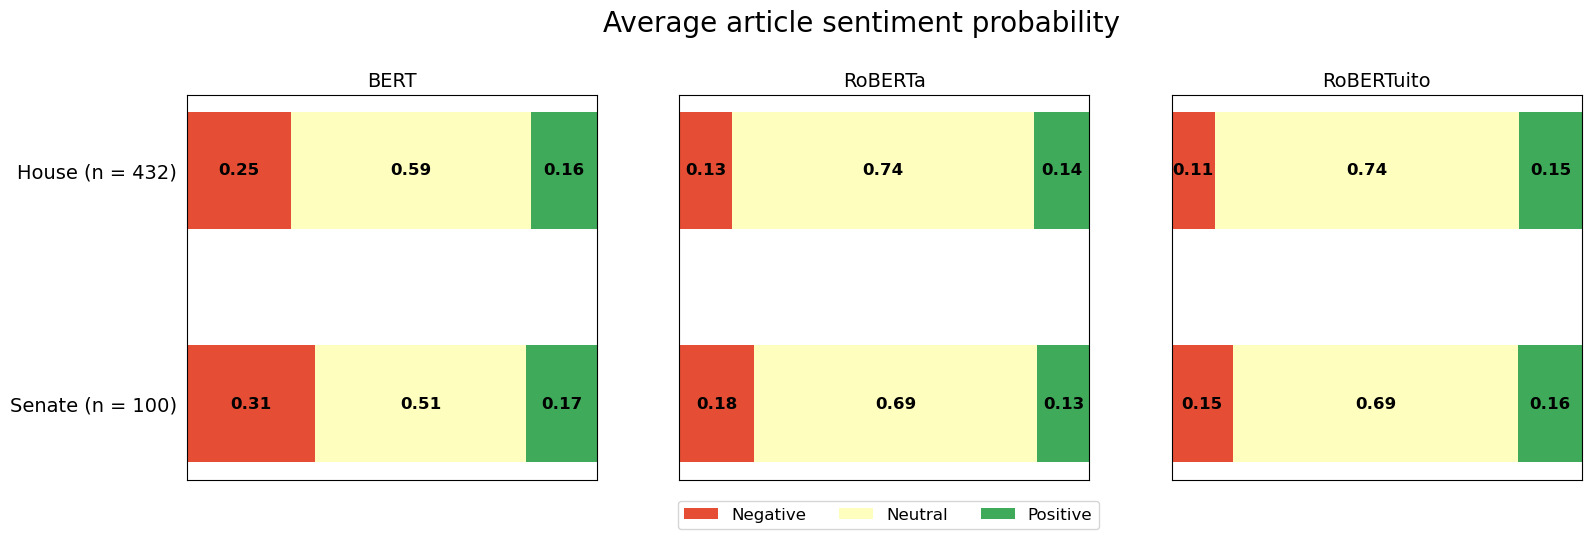

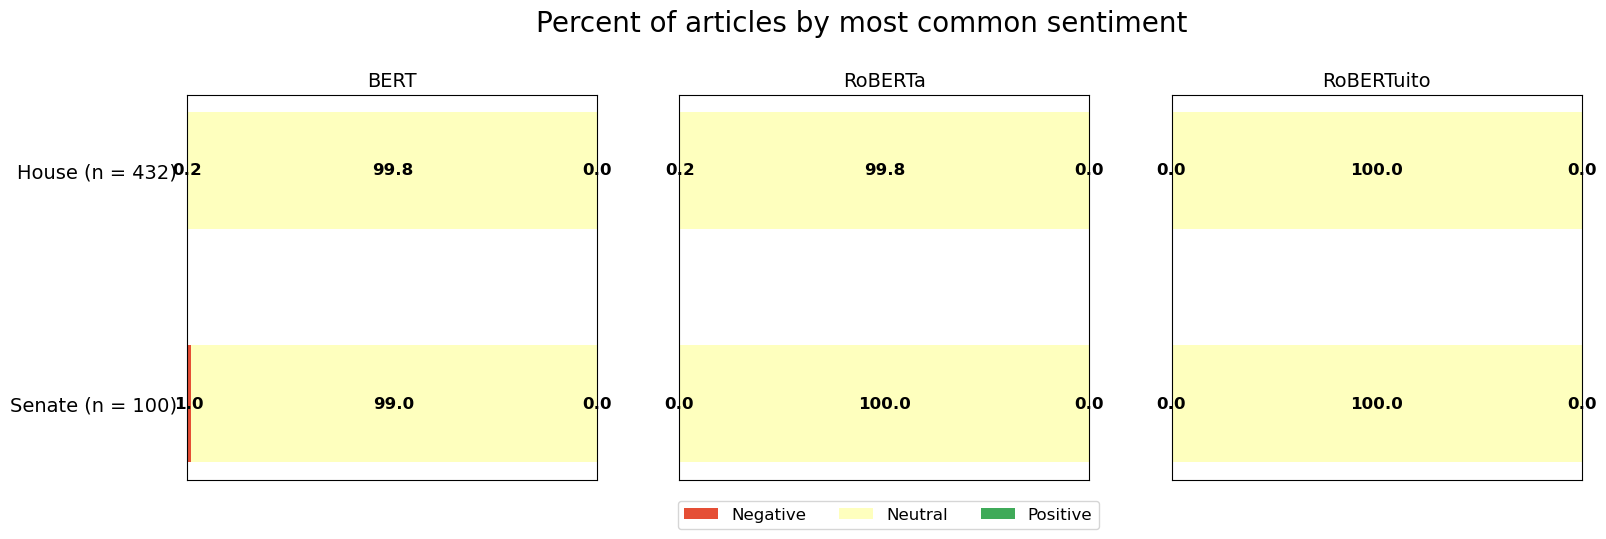

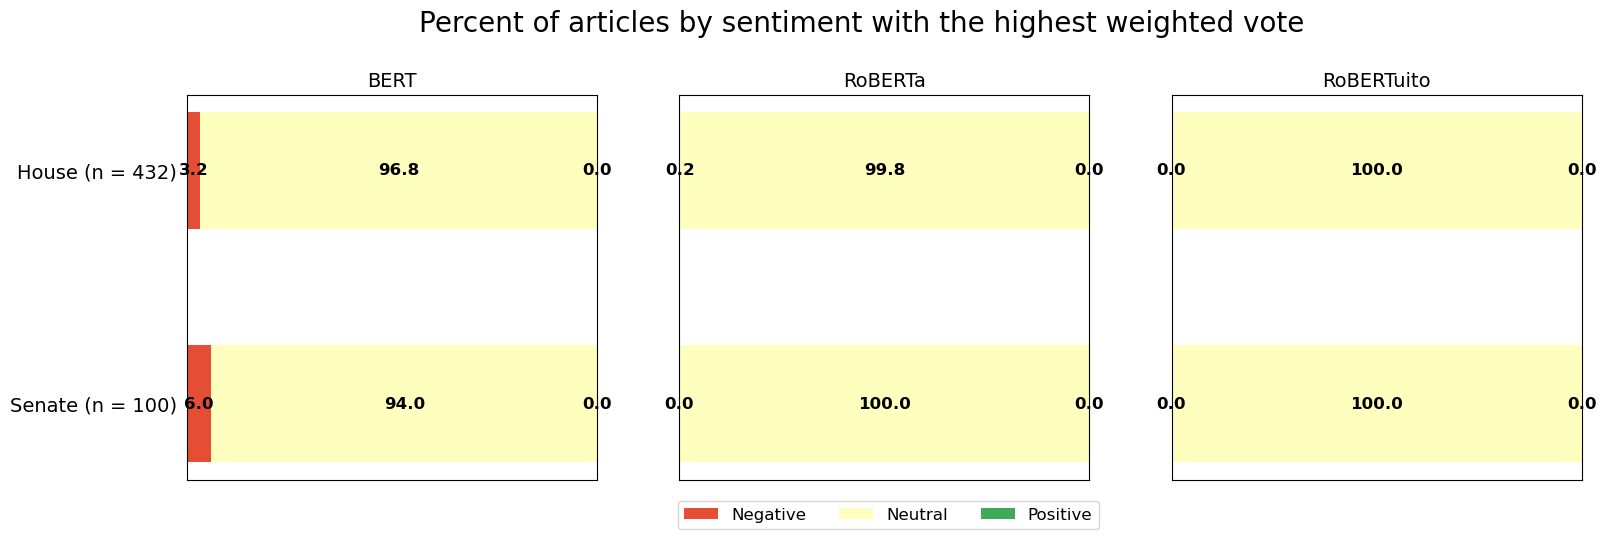

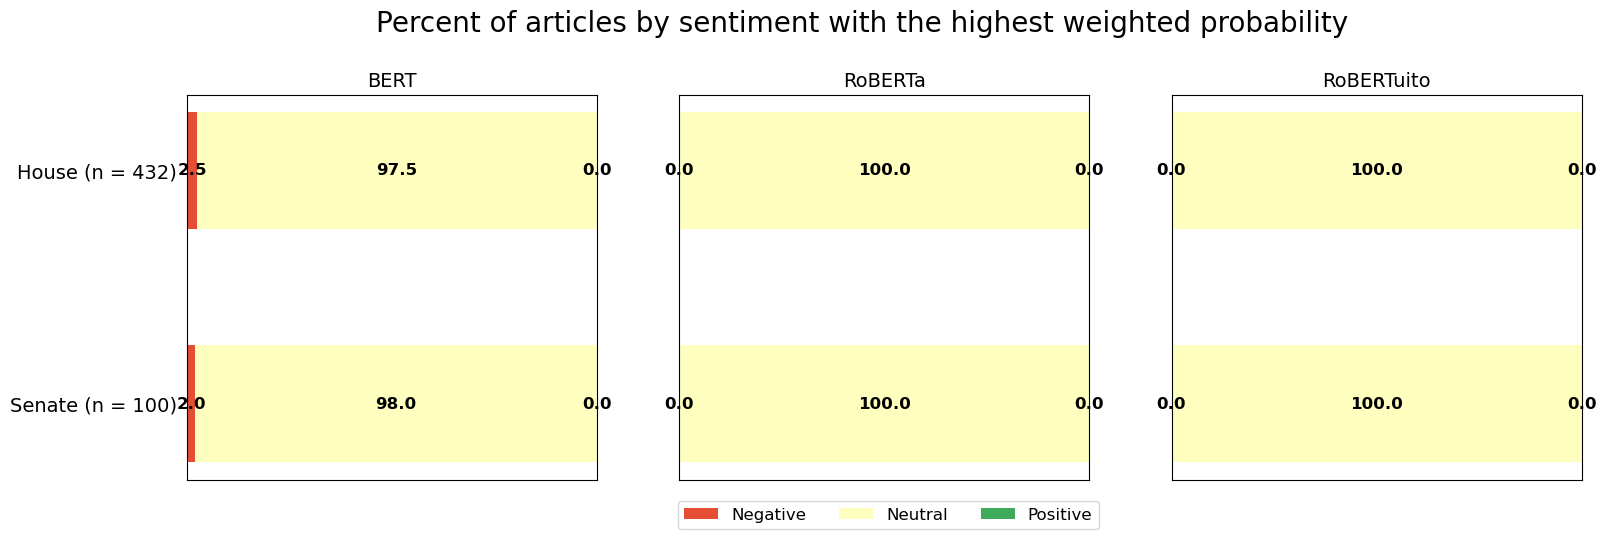

In [5]:
label_cols=['Chamber']

plot_group(models,input_filename,label_cols,plot_metric='avg_paragraph_percent',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='avg_article_prob',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='percent_most_common',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='percent_highest_weighted_vote',save_fig=False,min_group_size=min_group_size)
plot_group(models,input_filename,label_cols,plot_metric='percent_highest_weighted_prob',save_fig=False,min_group_size=min_group_size)

Interestingly, most of the group metrics identify more negative sentiment amongst articles about Senators compared to those about House members. Let's see if we can gain any more insight into this finding. One could hypothesize that the longer someone is in Congress, the more negative sentiment about them will be. Let's plot the correlations between article sentiment probability and tenure length in years.

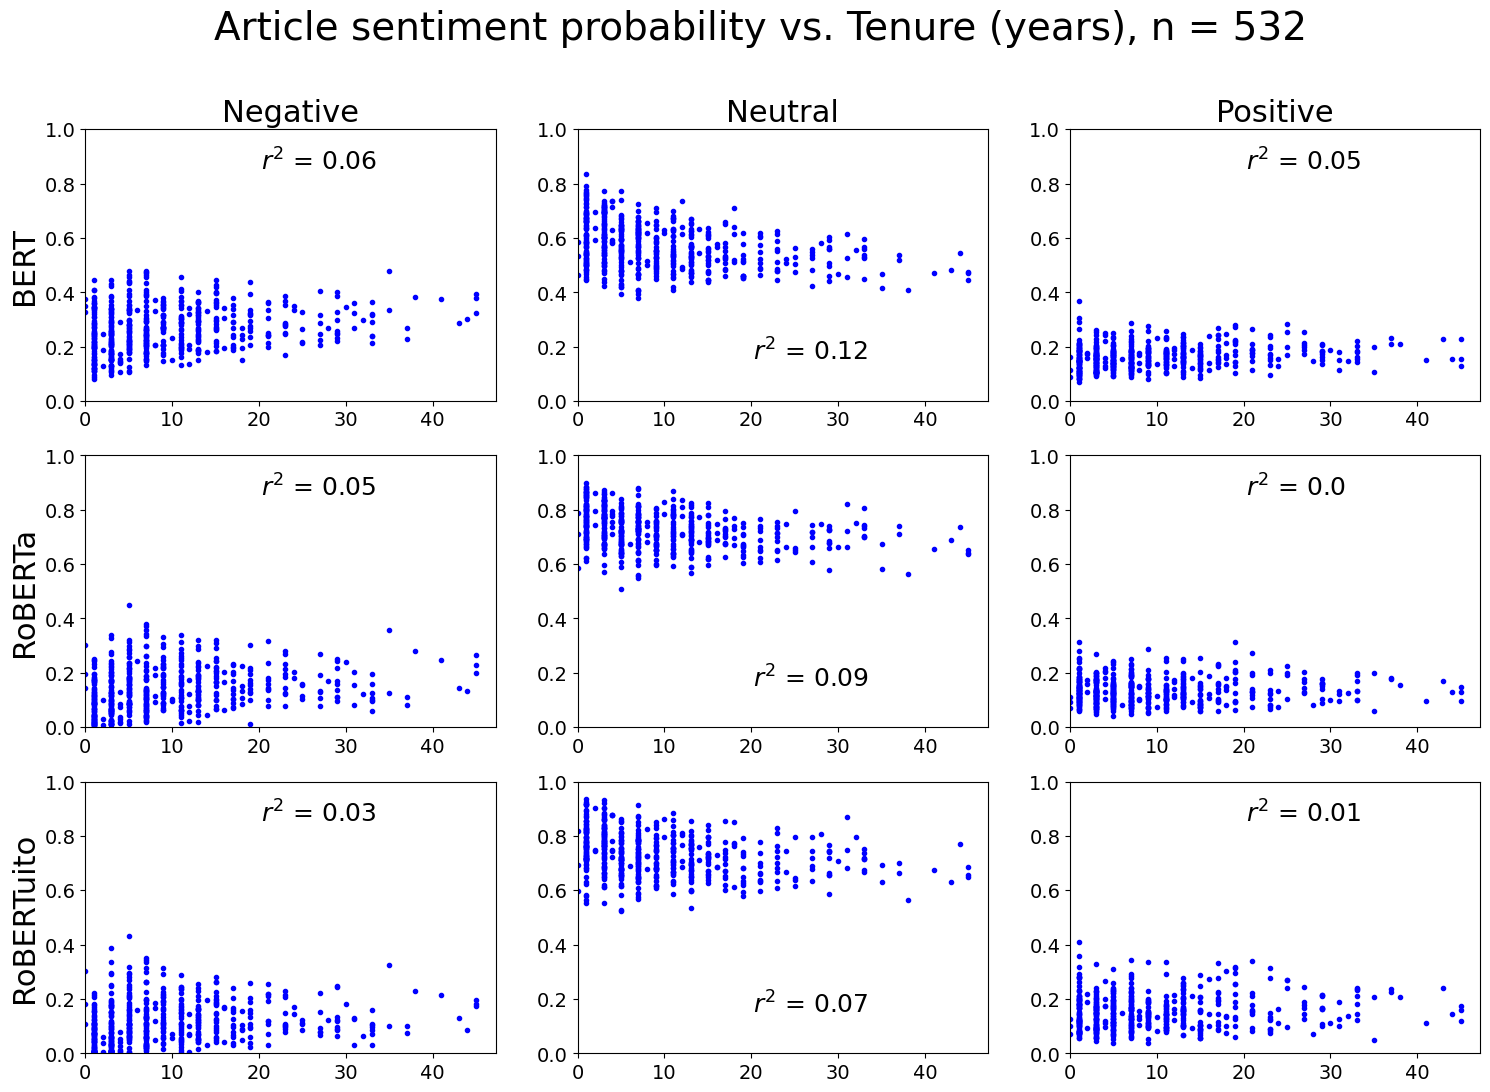

In [6]:
x_col='Tenure (years)'
plot_corrs(models,input_filename,x_col,plot_metric='article_prob',save_fig=False)

This hypothesis seems to be falsified: there is no observable relationship between article sentiment probability and a Congress member's length of tenure. Let's do the same analysis again, but this time we'll choose article length as our x variable instead of tenure length.

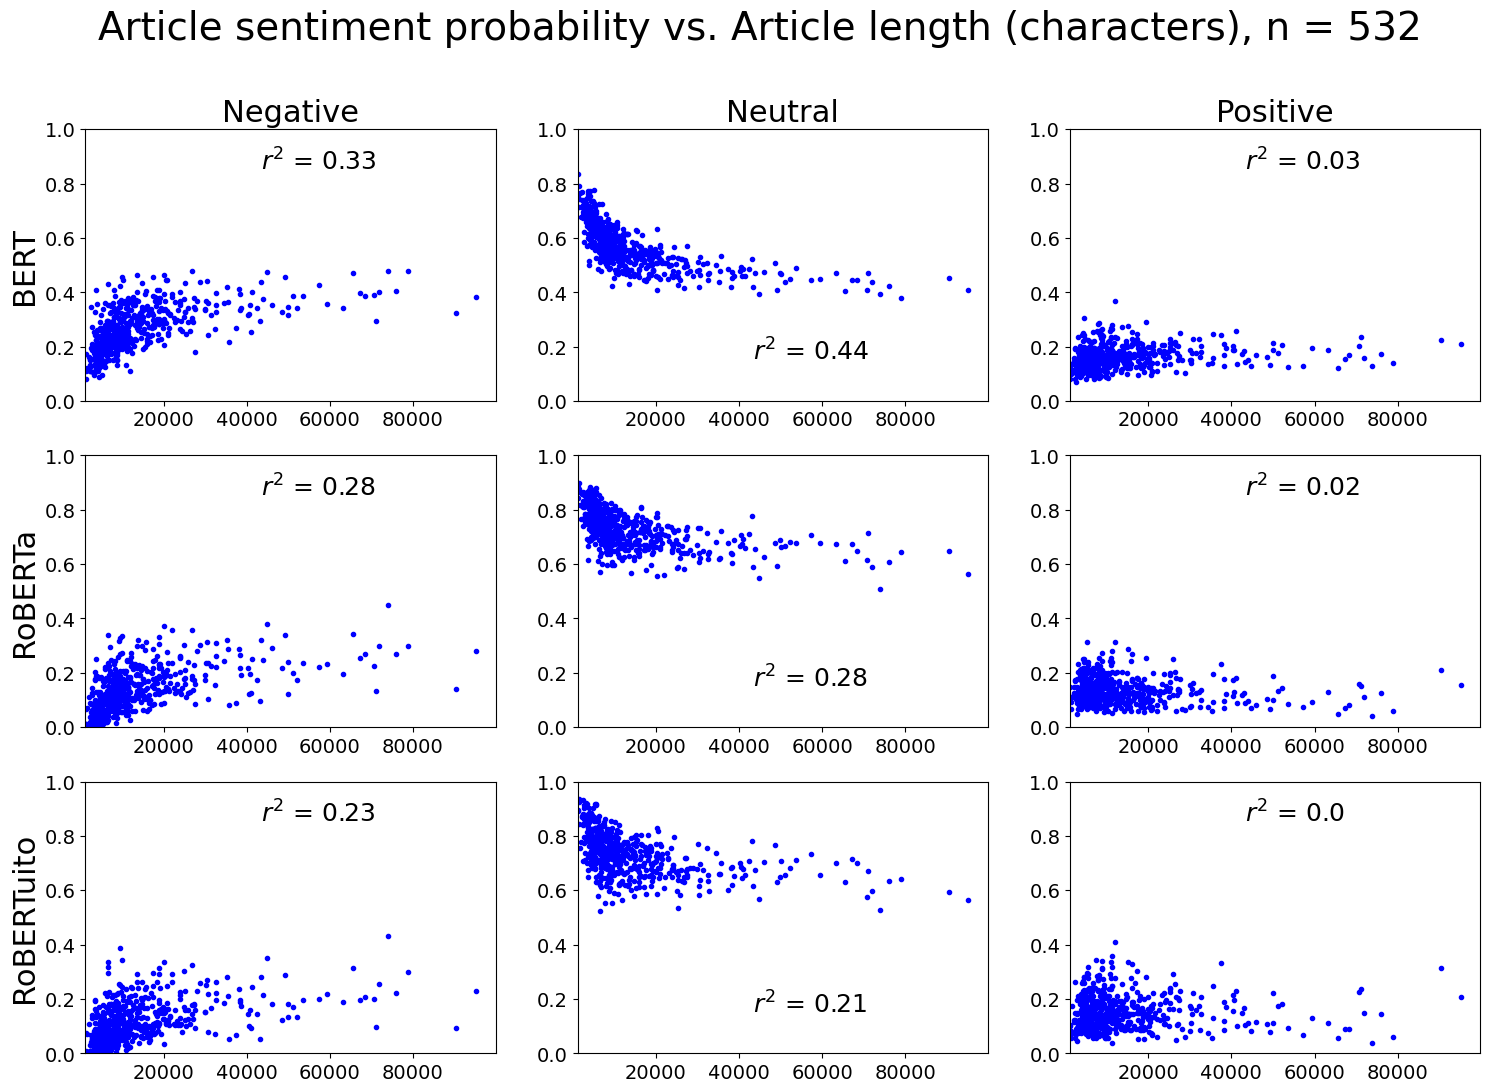

In [7]:
x_col='Article length (characters)'
plot_corrs(models,input_filename,x_col,plot_metric='article_prob',save_fig=False)

These correlations are not incredibly strong but there's definitely something here! It seems that as the length of the article increases, negative sentiment tends to increase while neutral sentiment tends to decrease. Positive sentiment seems to be completely unaffected. One explanation for this could be that for this dataset, all articles contain biographical sections (Early life, Education, etc.) that are highly neutral in tone. As article length increases, there will likely be more discussions of policy positions or controversies that contain negative sentiment. Going back to our discussion of sentiment for House vs. Senate members, let's look at the average article length for both categories.

In [8]:
import pandas as pd

df=pd.read_csv(input_filename)
df.groupby('Chamber')['Article length (characters)'].mean()

Chamber
House     11004.451389
Senate    27861.890000
Name: Article length (characters), dtype: float64

As we can see, the average Wikipedia article for a Senator is well over twice as long as the average Wikipedia article for a House member. Thus, it seems reasonable to conclude that Senators attract more negative sentiment because they're more well-known than House members, and their longer articles will simply reflect the criticism that comes with greater notoriety. But wait, you ask: what if the reason that longer articles are more negative is *because* they're about Senators, rather than articles about Senators being more negative because they're longer? To address this concern, we should look at the trends within both the House and the Senate.

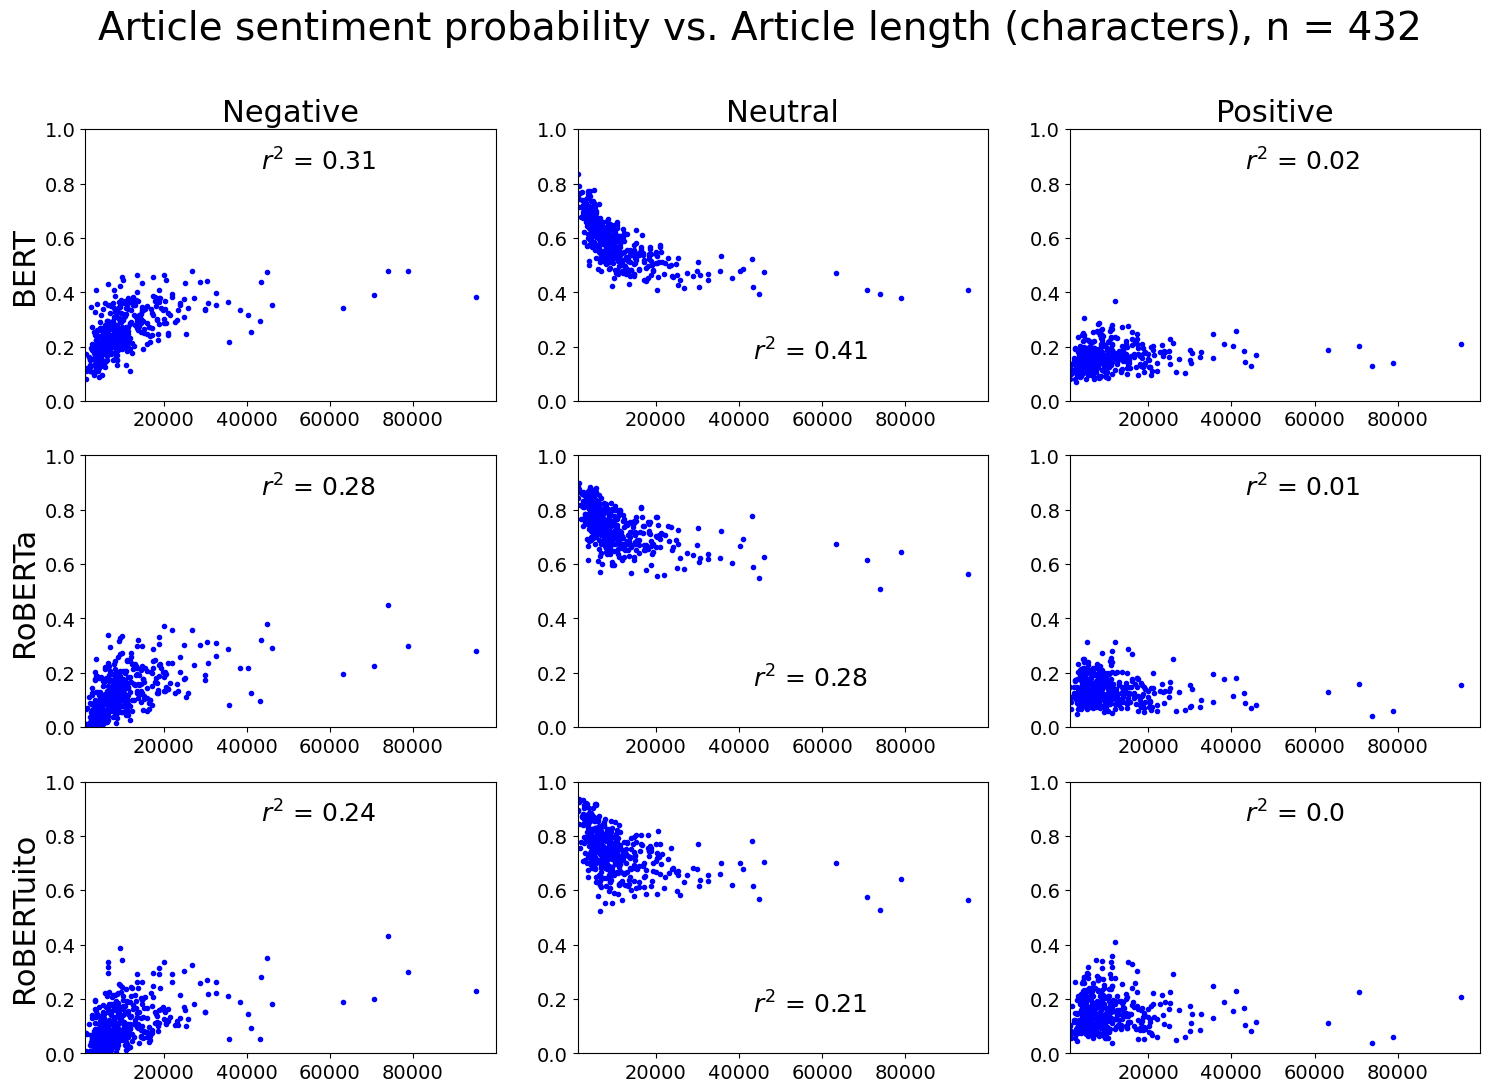

In [9]:
filter_cols=['Chamber']
filter_values=[['House']]
plot_corrs(models,input_filename,x_col,plot_metric='article_prob',save_fig=False,filter_cols=filter_cols,filter_values=filter_values)

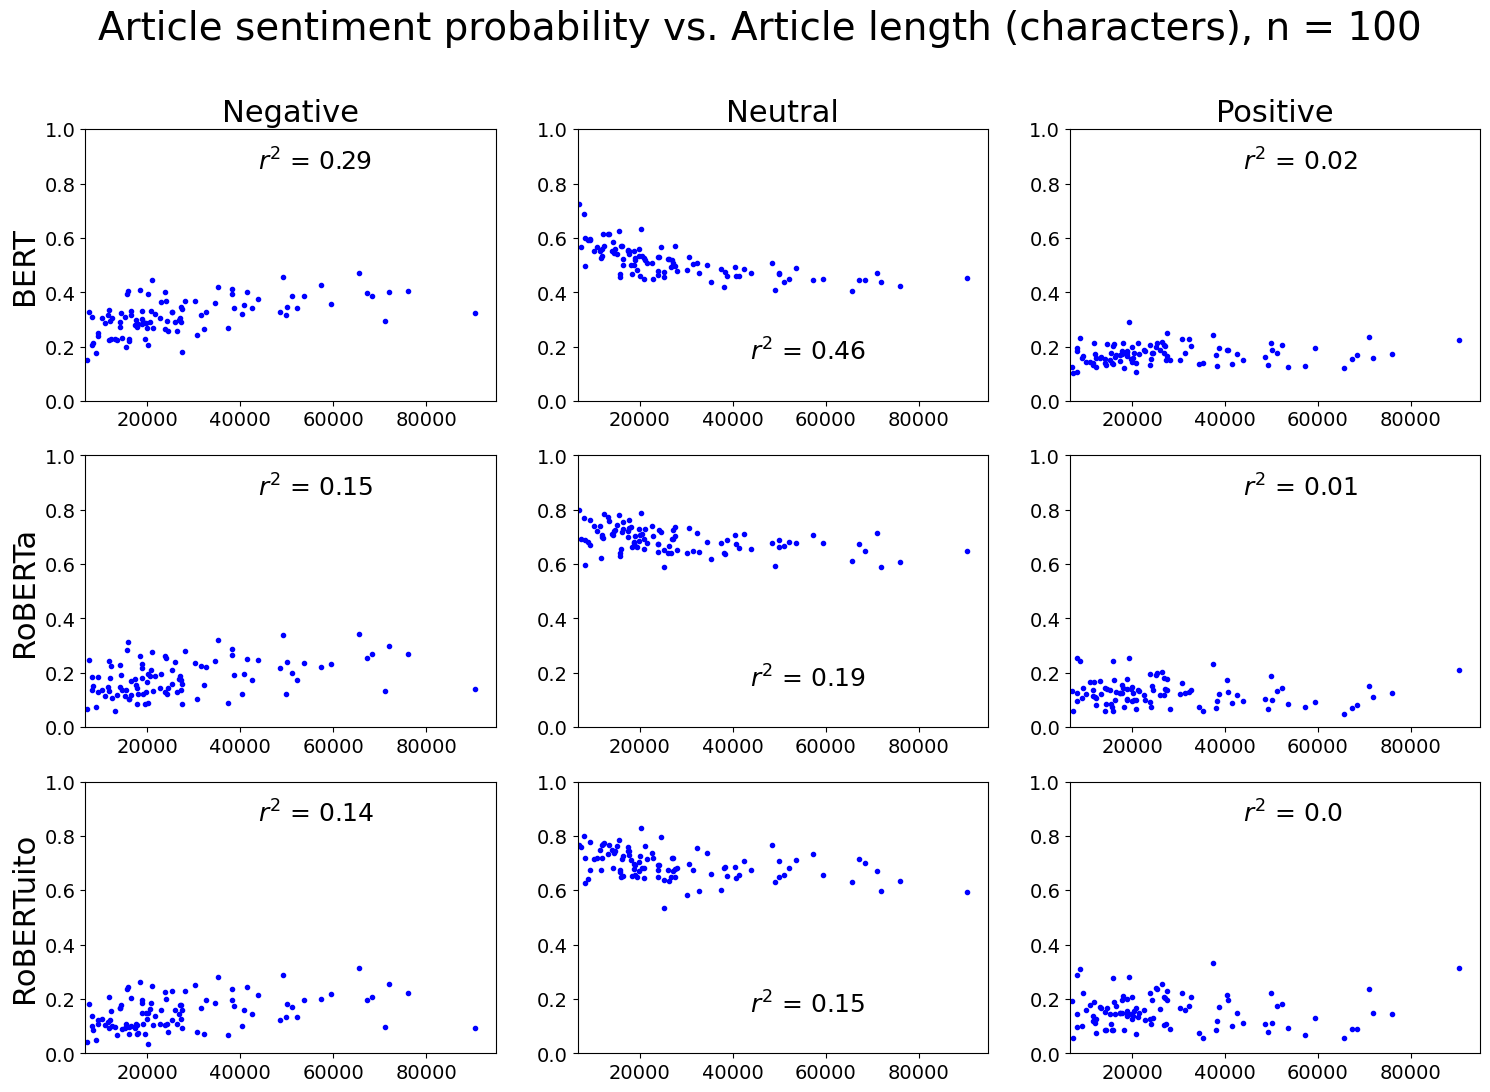

In [10]:
filter_values=[['Senate']]
plot_corrs(models,input_filename,x_col,plot_metric='article_prob',save_fig=False,filter_cols=filter_cols,filter_values=filter_values)

As we can see, the trends continue to exist even after separating by chamber, although they're quite weak for the Senate outside of the BERT model. In any case, we can safely conclude that the trends of increasing negative sentiment and decreasing neutral sentiment with increasing article length are not caused by Senate articles simply being more negative and less neutral than House articles. Rather, it seems more likely that there is a general trend that as article length increases, negative sentiment increases and neutral sentiment decreases, and the differences in sentiment between House and Senate articles can be explained by this trend.